In [2]:
import cmasher as cmr
from matplotlib import rcParams
import matplotlib.pyplot as plt
colors = cmr.take_cmap_colors('cmr.bubblegum', 6, cmap_range=(0.05, 0.95), return_fmt='hex')
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14
rcParams['mathtext.default'] = 'regular'
from matplotlib import colors as cr
import pandas as pd
import seaborn as sns
import numpy as np
from astropy.cosmology import Planck18_arXiv_v2 as Planck18
from astropy import units as u
import scipy

import catgen
import sfh
import param_dists as pdf

### Set up some helpful information for the Catalog class we are going to specify. 
####  - n_sample is the number of draws in metallicity and redshift we will take from the cosmic star formation history
####  - n_downsample is the factor by which we downsample the draws
####  - the path and label strings help with reading in data
####  - mets is our metallicity grid

In [3]:
n_sample = 10000000
n_downsample=100
path = '../alpha_1'
label = r'$\alpha=1$'
mets = np.logspace(np.log10(0.0001), np.log10(0.03), 30)
mets = mets[:-1]

### First, we initialize our catalog class with our chosen star formation history model (btwn Madau & Dickinson 2014 or Madau & Fragos 2017), the metallicity grid, and the kstar types and SF data for reading in the COSMIC data

In [4]:
cat = catgen.Catalog(dat_path=path,                     
                     sfr_model=sfh.mf_17,
                     met_grid=mets, 
                     kstar_1='14', 
                     kstar_2='14', 
                     SFstart=13700.0, 
                     SFduration=0.0)



/mnt/ceph/users/kbreivik/merger_catalog/cosmic-mergers/utils.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  dat = np.array(dat)


#### Check how the grid looks with the BBH formation efficiency

Text(0, 0.5, 'BBH formation efficiency [M$_{\\odot}^{-1}$]')

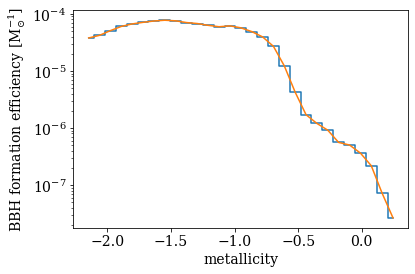

In [5]:
plt.plot(np.log10(mets/0.014), cat.n_BBH/cat.M_sim, drawstyle='steps-mid')
plt.plot(np.log10(mets/0.014), cat.n_BBH/cat.M_sim)
plt.yscale('log')
plt.xlabel('metallicity')
plt.ylabel('BBH formation efficiency [M$_{\odot}^{-1}$]')

### Even though the number of sources per grid varies, since we normalize by the total amount of mass drawn from the IMF/mass ratio distribution, the formation efficiency changes smoothly.

Text(0, 0.5, 'N per metallicity grid')

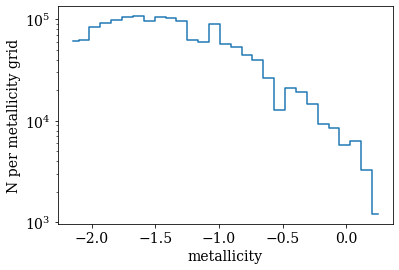

In [6]:
plt.plot(np.log10(mets/0.014), cat.n_BBH, drawstyle='steps-mid')
plt.yscale('log')
plt.xlabel('metallicity')
plt.ylabel('N per metallicity grid')

### build a catalog which contains mergers in a comoving volume of [Gpc$^3$]

The catalog building process draws `n_sample` metallicities and redshifts which specify ZAMS formation metallicities and redshifts to our BBH mergers. Since the MD14 and MD17 star formation rates are reported as $\frac{dM}{dtdV}(z)$, which is the total amount of mass formed per year per comoving Gpc$^3$ and we would like to sample $\frac{dM}{dzdV}(z)$, we need to transform the star formation rate as $\frac{dM}{dzdV}(z) = \frac{dM}{dtdV}(z) \frac{dt}{dz}(z)$. Now, all of the BBH mergers in the catalog we generate will be for a comoving volume of $1\rm{Gpc}^3$.

Note that sigma_logZ is the standard deviation of the metallicity distribution, where the mean is specified by Madau and Fragos 2017.  Also note that both sigma_logZ and z_max are not necessary to specify if you want to use the default values which are sigma_logZ=0.5 and z_max=20.

Once we sample a bunch of ZAMS formation redshifts and metallicities, we can attach each formation redshift and metallicity to a BBH merger. We then log the formation lookback time, and the merger lookback time. To make the normalization of the rate kdes easy in future calculations, we don't filter out systems with merger lookback times that will occur in the future (i.e. $t_{\rm{merge}} < 0$). During this sampling process, we also keep track of the metallicity grid point that each BBH is attached to so that we can normalize the mass formed in the star formation history to the average amount of mass formed per BBH merger at a given metallicity, which we define as $M_{\rm{BBH,mean}}(Z)$.

After the sampling process, we need to figure out how to normalize our catalog of BBH mergers in a comoving volume to a Universe of stars formed in a comoving volume. The total amount of stars formed in a comoving volume is just $M_{\rm{\star,com}} = \frac{dM}{dV} = \int_{0}^{t_{\rm{lb}}(z_{\rm{max}})} dt_{\rm{lb}} \frac{dM}{dtdV}(z(t_{\rm{lb}}))$. Then the conversion to the number of BBH mergers per comoving volume at any lookback time (or redshift) can be calculated by using the normalization factor: $\frac{M_{\rm{\star,com}}}{M_{\rm{BBH,mean}}}$, where $M_{\rm{BBH,mean}}$ is the average amount of mass formed per BBH merger at metallicity $Z$.

Now that we have a catalog of mergers including their formation redshifts, formation lookback times, and merger lookback times, as well as the normalization factor to scale our catalog to the Universe, we are ready to look at the merger distributions!

In [7]:
mergers, norm_fac = cat.build_cat(n_sample=n_sample, n_downsample=n_downsample, sigma_logZ=0.5, z_max=20)

100%|██████████| 29/29 [00:03<00:00,  7.89it/s]


#### Build the pdf of the merger lookback time distribution

In [8]:
p_tlb = pdf.get_dN_dtlb_dV(np.array(mergers.t_merge, dtype=float))


#### generate a set of lookback times and redshifts to evaulate the pdf
Note that everything is in units of a comoving volume already so no conversion is necessary to make this kde! Also, since the units of a pdf of $t_{\rm{lb}}$ are [yr$^{-1}$] and our catalog is in units of [Gpc$^{-3}$], the pdf we created has units of [yr$^{-1}$Gpc$^{-3}$] and the rate per comoving volume is just the pdf multiplied by the normalization factor.

In [9]:
z_max = 15
z = np.expm1(np.linspace(0, np.log1p(z_max), 1000))
tlb = Planck18.lookback_time(z).to(u.Myr).value

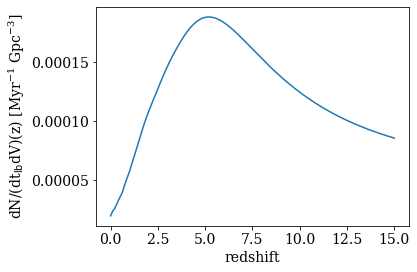

In [10]:
plt.plot(z, p_tlb(tlb))
plt.xlabel('redshift')
plt.ylabel(r'dN/(dt$_{\rm{lb}}$dV)(z) [Myr$^{-1}$ Gpc$^{-3}$]')
plt.tight_layout()

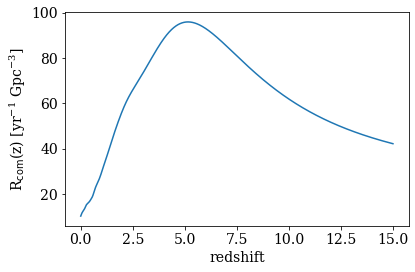

In [12]:
plt.plot(z, p_tlb(tlb) * norm_fac)
plt.xlabel('redshift')
plt.ylabel(r'R$_{\rm{com}}$(z) [yr$^{-1}$ Gpc$^{-3}$]')
plt.tight_layout()

#### we can zoom into the nearby universe to get the rate that LIGO can observe.

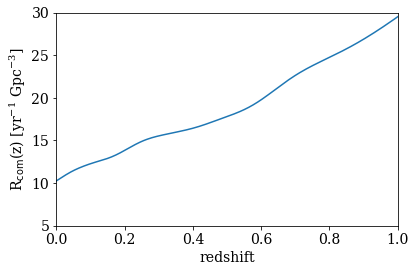

In [14]:
plt.plot(z, p_tlb(tlb) * norm_fac)
plt.xlabel('redshift')
plt.ylabel(r'R$_{\rm{com}}$(z) [yr$^{-1}$ Gpc$^{-3}$]')
plt.xlim(0, 1)
plt.ylim(5, 30)
plt.tight_layout()

#### We can also get the pdf of merger redshifts in the universe as measured from the detector frame

In this case, since we are moving out of the comoving detector frame, we will need a Jacobian to convert our comoving volume catalog to the full universe volume *and* a Jacobian to convert the merger redshift in the source frame to the detector frame. The process is then to build a kde of the merger lookback times which gives us $\frac{dN}{dtdV}$ and multiply by $\frac{dV}{dz}$ and $\frac{dt_{\rm{source}}}{dt_{\rm{detector}}} = \frac{1}{1 + z_{\rm{merge}}}$, this gives us $\frac{dN}{dt_{\rm{det}}dz} = \frac{dN}{dt_{\rm{source}}dV}\frac{dV}{dz}\frac{dt_{\rm{source}}}{dt_{\rm{detector}}}$. Now if we want to properly normalize the pdf $\frac{dN}{dt_{\rm{det}}dz}$, we integrate over the lookback times as $\rm{norm} = \int dt_{\rm{det}} \frac{dN}{dt_{\rm{det}}dz}$, then $p(z,t) = \frac{1}{\rm{norm}}{\frac{dN}{dt_{\rm{det}}dz}}$.

In [15]:
pz = pdf.get_pz(np.array(mergers.t_merge, dtype=float), z_max=15)

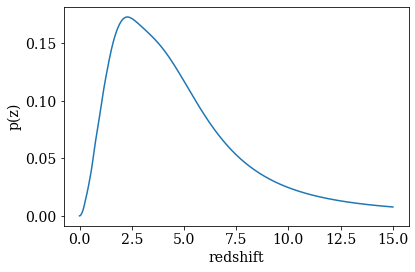

In [16]:
plt.plot(z, pz(z))
plt.xlabel('redshift')
plt.ylabel(r'p(z)')
plt.tight_layout()

#### And if we want to get the rate per mass per q

In [17]:
m1 = np.array(mergers.m1, dtype=float)
m2 = np.array(mergers.m2, dtype=float)
q = m2/m1
t = np.array(mergers.t_merge, dtype=float)

In [23]:
primary_mass = np.where(m1 > m2, m1, m2)
mass_ratio = np.where(m1 > m2, m2/m1, m1/m2)

In [25]:
dN_dtlb_dlnm_dV = pdf.get_dN_dtlb_dlnm_dV(t_lb=t, m=primary_mass)
dN_dtlb_dlnm_dlogitq_dV = pdf.get_dN_dtlb_dlnm_dq_dV(t_lb=t, m=primary_mass, q=mass_ratio)

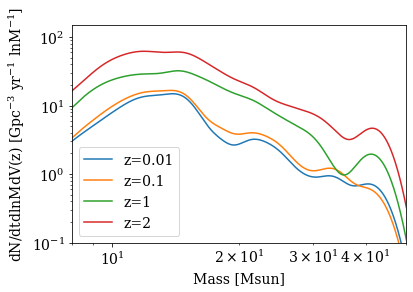

In [22]:
plt.plot(np.linspace(0.1, 50, len(tlb)), dN_dtlb_dlnm_dV(Planck18.lookback_time(0.01).to(u.Myr), 
                                                       np.linspace(0.1, 50, len(tlb))) * norm_fac, 
         label='z=0.01')
plt.plot(np.linspace(0.1, 50, len(tlb)), dN_dtlb_dlnm_dV(Planck18.lookback_time(0.1).to(u.Myr), 
                                                       np.linspace(0.1, 50, len(tlb))) * norm_fac, 
         label='z=0.1')
plt.plot(np.linspace(0.1, 50, len(tlb)), dN_dtlb_dlnm_dV(Planck18.lookback_time(1).to(u.Myr), 
                                                       np.linspace(0.1, 50, len(tlb))) * norm_fac, 
         label='z=1')
plt.plot(np.linspace(0.1, 50, len(tlb)), dN_dtlb_dlnm_dV(Planck18.lookback_time(2).to(u.Myr), 
                                                       np.linspace(0.1, 50, len(tlb))) * norm_fac, 
         label='z=2')

plt.ylabel('dN/dtdlnMdV(z) [Gpc$^{-3}$ yr$^{-1}$ lnM$^{-1}$]')
plt.xlabel('Mass [Msun]')
plt.legend()
plt.ylim(0.1, 150)
plt.xlim(8, 50)
plt.xscale('log')
plt.yscale('log')

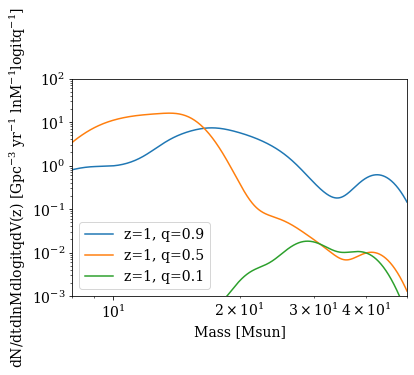

In [83]:
plt.plot(np.linspace(0.1, 50, len(tlb)), dN_dtlb_dlnm_dlogitq_dV(Planck18.lookback_time(1).to(u.Myr), 
                                                                 np.linspace(0.1, 50, len(tlb)),
                                                                 0.9) * norm_fac, 
         label='z=1, q=0.9')

plt.plot(np.linspace(0.1, 50, len(tlb)), dN_dtlb_dlnm_dlogitq_dV(Planck18.lookback_time(1).to(u.Myr), 
                                                                 np.linspace(0.1, 50, len(tlb)),
                                                                 0.5) * norm_fac, 
         label='z=1, q=0.5')

plt.plot(np.linspace(0.1, 50, len(tlb)), dN_dtlb_dlnm_dlogitq_dV(Planck18.lookback_time(1).to(u.Myr), 
                                                                 np.linspace(0.1, 50, len(tlb)),
                                                                 0.1) * norm_fac, 
         label='z=1, q=0.1')

plt.ylabel('dN/dtdlnMdlogitqdV(z) [Gpc$^{-3}$ yr$^{-1}$ lnM$^{-1} logitq^{-1}$]')
plt.xlabel('Mass [Msun]')
plt.legend()
plt.ylim(1e-3, 100)
plt.xlim(8, 50)
plt.xscale('log')
plt.yscale('log')

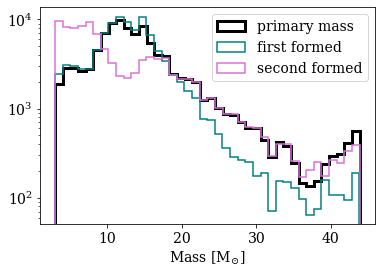

In [52]:
plt.hist(primary_mass, histtype='step', label='primary mass', bins=40, lw=3, color='black')
plt.hist(mergers.m1, histtype='step', label='first formed', bins=40, lw=1.5, color='teal')
plt.hist(mergers.m2, histtype='step', label='second formed', bins=40, lw=1.5, color='orchid')
plt.xlabel(r'Mass [M$_{\odot}$]')
plt.legend()
plt.yscale('log')

Text(0, 0.5, 'second formed mass [M$_{\\odot}$]')

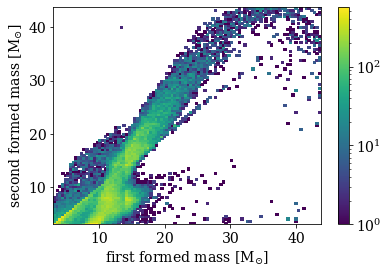

In [55]:
plt.hist2d(mergers.m1, mergers.m2, bins=100, norm=cr.LogNorm())
plt.colorbar()
plt.xlabel(r'first formed mass [M$_{\odot}$]')
plt.ylabel(r'second formed mass [M$_{\odot}$]')

In [73]:
X = np.log(mergers.t_form/1000) - np.log(max(mergers.t_form/1000 + 0.1) - mergers.t_form/1000)
Y = np.log(mergers.met/0.014) - np.log(max(mergers.met/0.014 + 0.001) - mergers.met/0.014)

In [74]:
Y[np.isinf(Y)]

Series([], Name: met, dtype: float64)

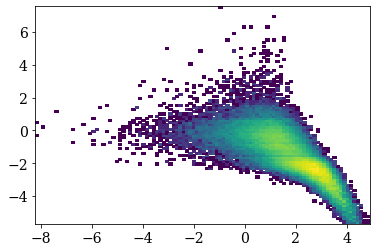

In [75]:
plt.hist2d(X, Y, bins=100, norm=cr.LogNorm());

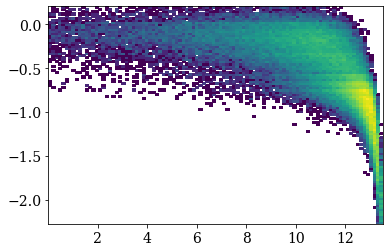

In [77]:
plt.hist2d(mergers.t_form/1000, np.log10(mergers.met/0.017), bins=100, norm=cr.LogNorm());

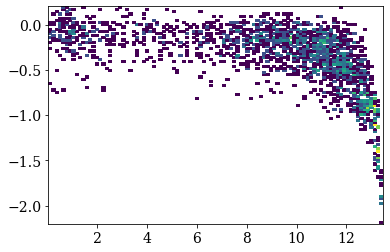

In [82]:
plt.hist2d(mergers.loc[(mergers.t_merge > 0) & (mergers.t_merge < 1000)].t_form/1000, 
           np.log10(mergers.loc[(mergers.t_merge > 0) & (mergers.t_merge < 1000)].met/0.017), bins=100, norm=cr.LogNorm());

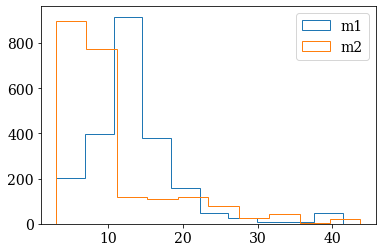

In [91]:
plt.hist(mergers.loc[(mergers.t_merge > 0) & (mergers.t_merge < 1000)].m1, histtype='step', label='m1')
plt.hist(mergers.loc[(mergers.t_merge > 0) & (mergers.t_merge < 1000)].m2, histtype='step', label='m2')
plt.legend()

In [99]:
mergers.loc[mergers.met > 0.009].m1.min(), mergers.loc[mergers.met > 0.009].m2.min()

(3.0000525636819497, 3.0001039330054313)

In [101]:
mergers.loc[mergers.m1 == mergers.m1.max()]


,t_form,t_merge,z_form,met,met_cosmic,m1,m2,bin_num
804,13337.664134,11931.047079,10.358579,0.000221,0.00022,43.825467,33.797511,243762.0
805,13337.664134,11931.047079,10.358579,0.000221,0.00022,43.825467,33.797511,243762.0


In [102]:
mergers.loc[mergers.m2 == mergers.m2.max()]

,t_form,t_merge,z_form,met,met_cosmic,m1,m2,bin_num
2397,13383.550557,12832.036302,11.202394,0.000408,0.000396,34.019572,43.839535,1227289.0
2398,13383.550557,12832.036302,11.202394,0.000408,0.000396,34.019572,43.839535,1227289.0
2399,13383.550557,12832.036302,11.202394,0.000408,0.000396,34.019572,43.839535,1227289.0
2400,13383.550557,12832.036302,11.202394,0.000408,0.000396,34.019572,43.839535,1227289.0
2401,13383.550557,12832.036302,11.202394,0.000408,0.000396,34.019572,43.839535,1227289.0
2402,13383.550557,12832.036302,11.202394,0.000408,0.000396,34.019572,43.839535,1227289.0
2403,13383.550557,12832.036302,11.202394,0.000408,0.000396,34.019572,43.839535,1227289.0
